In this notebook, you will

- Learn how to add a Reconfigurable Intelligent surface to a scene 
- Use ray tracing to simulate the effects of RIS on a wireless channel 
- Observe the changes in wireless channel upon configuring Phase, Gain and Polarization of an RIS antenna element

## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [2]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, RIS

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

## Loading and Viewing Scenes

In [4]:
# Load integrated scene
scene = load_scene(sionna.rt.scene.box) # Try also sionna.rt.scene.etoile

 # Open 3D preview (only works in Jupyter notebook)

print(f'size:{scene.size}' )
print(f'center:{scene.center}')

if colab_compat:
    scene.render(camera="scene-cam-0", num_samples=512);
    raise ExitCell
scene.preview(show_devices=True, show_paths=True)

size:[10.02      10.02       5.0200005]
center:[0.  0.  2.5]


Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

## Simulation Setup


In [5]:
scene.remove("tx")
scene.remove("rx")
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[-4,0,2.5])

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[3,0,2.5],
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver

scene.frequency = 2.4e9 # in Hz; implicitly updates RadioMaterials

scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

# Assign scattering coefficient to Radio material for some scattering
scene.get("ceiling").radio_material.scattering_coefficient = 0.5

In [6]:
subcarrier_spacing = 312.5e3
fft_size = 64
noise_floor = np.exp(0.1*(-174 + 10*np.log10(subcarrier_spacing) - 30 + 5))

frequencies = scene.frequency + subcarrier_frequencies(fft_size, subcarrier_spacing)

## Effect of Number of Antennas on the RIS

Here we observe the effect of reflected power from the RIS for (2 x 2 and 4 x 4) RIS antenna array sizes. 
First of all we observe that the frequency response of the RIS channel is not flat because we included the multipath effect by setting the *tx_to_ris_env* and *rx_to_ris_env* flags to True.

Next, we see that going to a 4 x 4 array from a 2 x 2 array increases the number of RIS antennas by 4 times. Theoretically, this should correspond to 16 times higher reflected energy towards the receiver. We observe around 8 to 12 dB increase in the power across sub-carriers.


In [6]:
# Introduce RIS array. Note : Polarization must be VH for RIS array
tf.random.set_seed(1) # Set the same seed before every ray tracing for consistent observations
ris_array_2x2 = PlanarArray(num_rows=2,
                             num_cols=2,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="VH")

ris_2x2 = RIS(name="ris", position = [-5,0,2.5],ris_array=ris_array_2x2,ris_phases=None)
h_ris_2x2,_,_ = ris_2x2.ris_channel(scene,frequencies,tx_to_ris_env=True,rx_to_ris_env=True,phase_optimizer=True)

tf.random.set_seed(1)
ris_array_4x4 = PlanarArray(num_rows=4,
                             num_cols= 4,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="VH")

ris_4x4 = RIS(name="ris", position = [-5,0,2.5],ris_array=ris_array_4x4,ris_phases=None)
h_ris_4x4,_,_ = ris_4x4.ris_channel(scene,frequencies,tx_to_ris_env=True,rx_to_ris_env=True,phase_optimizer=True)

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


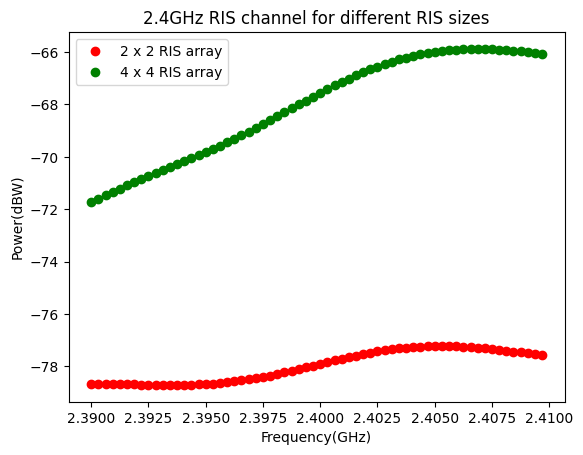

In [7]:
a = h_ris_2x2[0,0,0,0,0,0,:].numpy()
b = h_ris_4x4[0,0,0,0,0,0,:].numpy()

plt.figure();
plt.plot(frequencies/1e9,20*np.log10(a),'ro',label='2 x 2 RIS array')
plt.plot(frequencies/1e9,20*np.log10(b),'go',label = '4 x 4 RIS array')
plt.xlabel("Frequency(GHz)")
plt.ylabel("Power(dBW)")
plt.title("2.4GHz RIS channel for different RIS sizes")
plt.legend()

By disabling the *tx_to_ris_env* and *rx_to_ris_env* flags, we can see that the RIS channel response looks flat and the increase in power will be very close to 12 dB.

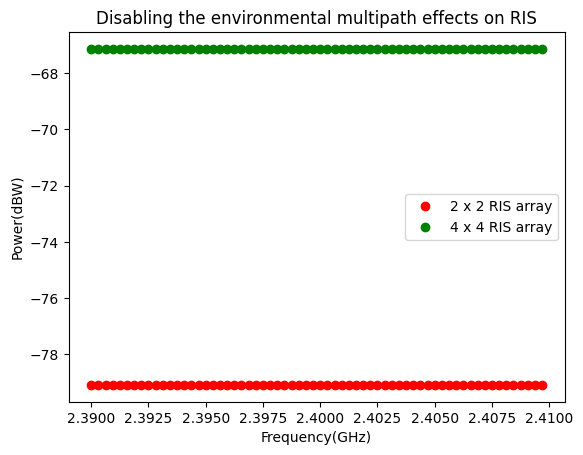

In [8]:
h_ris_2x2,_,_ = ris_2x2.ris_channel(scene,frequencies,tx_to_ris_env=False,rx_to_ris_env=False,phase_optimizer=True)

h_ris_4x4,_,_ = ris_4x4.ris_channel(scene,frequencies,tx_to_ris_env=False,rx_to_ris_env=False,phase_optimizer=True)

a = h_ris_2x2[0,0,0,0,0,0,:].numpy()
b = h_ris_4x4[0,0,0,0,0,0,:].numpy()

plt.figure();
plt.plot(frequencies/1e9,20*np.log10(a),'ro',label='2 x 2 RIS array')
plt.plot(frequencies/1e9,20*np.log10(b),'go',label = '4 x 4 RIS array')
plt.xlabel("Frequency(GHz)")
plt.ylabel("Power(dBW)")
plt.title("Disabling the environmental multipath effects on RIS")
plt.legend()

## Effect of Amplitude gain at the RIS element


Here we compare the reflected power from a 4 x 4 RIS with no gain and a 4 x 4 RIS with 2 times amplitude gain. In theroy we would expect the 2 x amplitude gain to result in 6 dB power gain across all sub-carriers. As expected, we observe 6 dB increase in the reflected power from the RIS. 

In [9]:
# Introduce RIS array. Note : Polarization must be VH for a RIS array
tf.random.set_seed(1) # Set the same seed before every ray tracing for consistent observations
ris_array = PlanarArray(num_rows=4,
                             num_cols=4,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="VH")

# By default, gain is 1 at each RIS element
ris = RIS(name="ris", position = [-5,0,2.5],ris_array=ris_array,ris_phases=None)
h_ris_no_gain,_,_ = ris.ris_channel(scene,frequencies,tx_to_ris_env=True,rx_to_ris_env=True,phase_optimizer=True)

tf.random.set_seed(1)
# RIS with 3 dB gain
gain_tensor = 2*tf.ones((ris_array.array_size),dtype=tf.complex64) # Amplitude Gain of 3 dB
ris.ris_element_gains = gain_tensor
h_ris_with_gain,_,_ = ris.ris_channel(scene,frequencies,tx_to_ris_env=True,rx_to_ris_env=True,phase_optimizer=True)

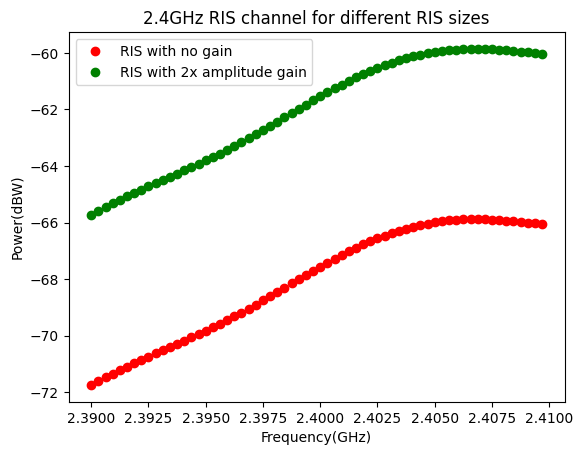

In [10]:
a = h_ris_no_gain[0,0,0,0,0,0,:].numpy()
b = h_ris_with_gain[0,0,0,0,0,0,:].numpy()

plt.figure();
plt.plot(frequencies/1e9,20*np.log10(a),'ro',label='RIS with no gain')
plt.plot(frequencies/1e9,20*np.log10(b),'go',label = 'RIS with 2x amplitude gain')
plt.xlabel("Frequency(GHz)")
plt.ylabel("Power(dBW)")
plt.title("2.4GHz RIS channel for different RIS sizes")
plt.legend()

## Effect of Polarization transfer matrix at RIS element

Here we compare the reflected power from a RIS that reflects the incident signal as it is without changing the polarization and another RIS that converts the incident vertical polarization to horizontal polarization and reflect the signal.

In the first case, the polarization transfer matrix looks like $$\left [\begin{matrix} 1 & 0 \\ 0 & 1 \end{matrix}\right]$$.

In the second case, the polarization transfer matrix looks like $$\left [\begin{matrix} 0 & 1 \\ 1 & 0 \end{matrix}\right]$$.

In [7]:
tf.random.set_seed(1) # Set the same seed before every ray tracing for consistent observations
ris_array = PlanarArray(num_rows=4,
                             num_cols=4,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="VH")
ris = RIS(name="ris", position = [-5,0,2.5],ris_array=ris_array,ris_phases=None)

# No polarization change
tf.random.set_seed(1)
ris.element_transfer_matrix = tf.constant([[1,0],[0,1]],dtype=tf.complex64)
h_ris,_,_ = ris.ris_channel(scene,frequencies,tx_to_ris_env=True,rx_to_ris_env=True,phase_optimizer=True)

# Change the incident horizontal to vertical polarization and vertical to horizontal polarizations
tf.random.set_seed(1)
ris.element_transfer_matrix = tf.constant([[0,1],[1,0]],dtype=tf.complex64)
h_ris_vh_to_hv,_,_ = ris.ris_channel(scene,frequencies,tx_to_ris_env=True,rx_to_ris_env=True,phase_optimizer=True)


Here both the transmitter and receiver are vertically polarized. The Signal incident at the RIS is vertically polarized. When the RIS changes the incident signal polarization from vertical to horizontal plane, it results in a polarization mismatch at the receiver and reduces the reflected signal power towards the Rx to a very small value.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


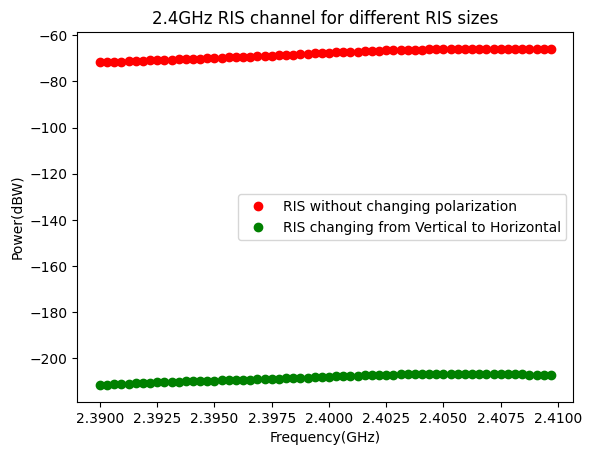

In [8]:
a = h_ris[0,0,0,0,0,0,:].numpy()
b = h_ris_vh_to_hv[0,0,0,0,0,0,:].numpy()

plt.figure();
plt.plot(frequencies/1e9,20*np.log10(a),'ro',label='RIS without changing polarization')
plt.plot(frequencies/1e9,20*np.log10(b),'go',label = 'RIS changing from Vertical to Horizontal polarization')
plt.xlabel("Frequency(GHz)")
plt.ylabel("Power(dBW)")
plt.title("2.4GHz RIS channel for different RIS sizes")
plt.legend()

## Effect of RIS on the cumulative wireless channel (Environment + RIS)

Finally, we look at the wireless channel considering the effects of RIS, Scattering and reflections from the environment. In this simulation, the RIS power is 20 dB smaller than the scattering in the environemnt and hence the wireless channel is not getting affected much by the presence of RIS. To make the affect more substantial, either we have to increase the size of the RIS or increase the gain at RIS.

In [9]:
ris.element_transfer_matrix = tf.constant([[1,0],[0,1]],dtype=tf.complex64)

tf.random.set_seed(1) # Set the same seed before every ray tracing for consistent observations
paths = scene.compute_paths(max_depth=1,
                                num_samples=10e6, reflection=True,scattering=True)  # Number of rays shot into directions defined
                                                # by a Fibonacci sphere, too few rays can
                                                # lead to missing paths
# Wireless channel from Tx to Rx (LoS only)
paths.normalize_delays = False
a, tau = paths.cir(reflection=False,scattering=False)
h_freq_los = cir_to_ofdm_channel(frequencies,
                                a,
                                tau,
                                normalize=False) # Non-normalized includes path-loss

# Wireless channel from Tx to Rx(LoS + scattering)
paths.normalize_delays = False
a, tau = paths.cir(reflection=True,scattering=True)
h_freq_env = cir_to_ofdm_channel(frequencies,
                                a,
                                tau,
                                normalize=False) # Non-normalized includes path-loss

tf.random.set_seed(1)
# Wireless channel from Tx to Rx via the RIS
h_freq_ris,h1,h2 = ris.ris_channel(scene,frequencies,tx_to_ris_env=True,rx_to_ris_env=True,phase_optimizer=True)

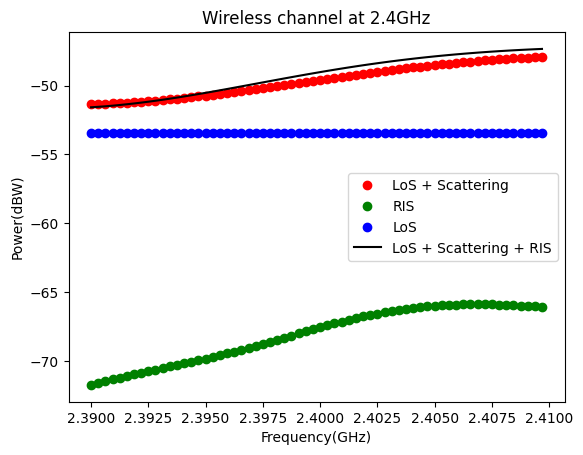

In [10]:
a = h_freq_env[0,0,0,0,0,0,:].numpy()
b = h_freq_ris[0,0,0,0,0,0,:].numpy()
c = h_freq_los[0,0,0,0,0,0,:].numpy()
d = a + b
plt.figure();
plt.plot(frequencies/1e9,20*np.log10(a),'ro',label='LoS + Scattering')
plt.plot(frequencies/1e9,20*np.log10(b),'go',label = 'RIS')
plt.plot(frequencies/1e9,20*np.log10(c),'bo',label = 'LoS')
plt.plot(frequencies/1e9,20*np.log10(d),'k-',label = 'LoS + Scattering + RIS')
plt.xlabel("Frequency(GHz)")
plt.ylabel("Power(dBW)")
plt.title("Wireless channel with 4 x 4 array")
plt.legend()

We will increase the size of the RIS to have a substantial affect on wireless channel. 

In [9]:
ris_array = PlanarArray(num_rows=4,
                             num_cols=12,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="VH")
ris = RIS(name="ris", position = [-5,0,2.5],ris_array=ris_array,ris_phases=None)
ris.element_transfer_matrix = tf.constant([[1,0],[0,1]],dtype=tf.complex64)

tf.random.set_seed(1) # Set the same seed before every ray tracing for consistent observations
paths = scene.compute_paths(max_depth=1,
                                num_samples=10e6, reflection=True,scattering=True)  # Number of rays shot into directions defined
                                                # by a Fibonacci sphere, too few rays can
                                                # lead to missing paths
# Wireless channel from Tx to Rx (LoS only)
paths.normalize_delays = False
a, tau = paths.cir(reflection=False,scattering=False)
h_freq_los = cir_to_ofdm_channel(frequencies,
                                a,
                                tau,
                                normalize=False) # Non-normalized includes path-loss

tf.random.set_seed(1) # Set the same seed before every ray tracing for consistent observations
# Wireless channel from Tx to Rx(LoS + scattering)
paths.normalize_delays = False
a, tau = paths.cir(reflection=True,scattering=True)
h_freq_env = cir_to_ofdm_channel(frequencies,
                                a,
                                tau,
                                normalize=False) # Non-normalized includes path-loss

# Wireless channel from Tx to Rx via the RIS
h_freq_ris,h1,h2 = ris.ris_channel(scene,frequencies,tx_to_ris_env=True,rx_to_ris_env=True,phase_optimizer=True)

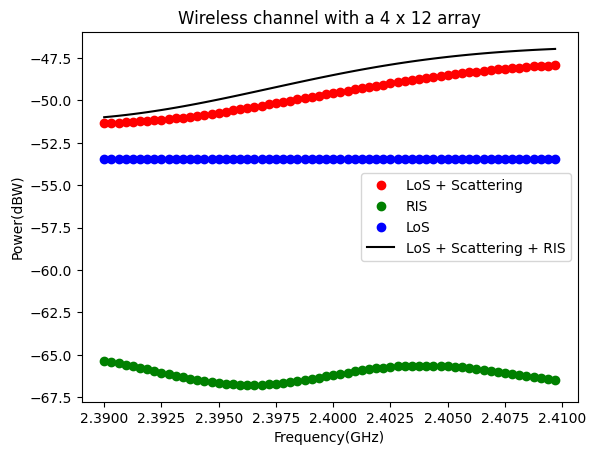

In [10]:
a = h_freq_env[0,0,0,0,0,0,:].numpy()
b = h_freq_ris[0,0,0,0,0,0,:].numpy()
c = h_freq_los[0,0,0,0,0,0,:].numpy()
d = a + b
plt.figure();
plt.plot(frequencies/1e9,20*np.log10(a),'ro',label='LoS + Scattering')
plt.plot(frequencies/1e9,20*np.log10(b),'go',label = 'RIS')
plt.plot(frequencies/1e9,20*np.log10(c),'bo',label = 'LoS')
plt.plot(frequencies/1e9,20*np.log10(d),'k-',label = 'LoS + Scattering + RIS')
plt.xlabel("Frequency(GHz)")
plt.ylabel("Power(dBW)")
plt.title("Wireless channel with a 4 x 12 array")
plt.legend()